In [28]:
#### ASSIGNMENT: 04
#### Task 02
#### CANDIDO REGIS

In [29]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.optimizers import Adam

In [30]:
# Define paths
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'dataset', 'NEU Metal Surface Defects Data')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

In [31]:
# Create binary classification structure (defective vs non-defective)
BINARY_DIR = os.path.join(BASE_DIR, 'binary_dataset')
BINARY_TRAIN = os.path.join(BINARY_DIR, 'train')
BINARY_VALID = os.path.join(BINARY_DIR, 'valid')
BINARY_TEST = os.path.join(BINARY_DIR, 'test')

In [32]:
# Create directories for binary classification
def create_binary_dataset(src_dir, dest_dir):
    # Remove existing directory if it exists
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    # Create defective and non-defective directories
    os.makedirs(os.path.join(dest_dir, 'defective'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'non_defective'), exist_ok=True)
    
    # All defect types are considered defective
    defect_types = os.listdir(src_dir)
    
    # Since we need at least one sample in each class for binary classification,
    # we'll create a dummy non-defective sample by copying one defective image
    # This is just for demonstration purposes
    dummy_created = False
    
    for defect_type in defect_types:
        src_defect_dir = os.path.join(src_dir, defect_type)
        if not os.path.isdir(src_defect_dir):
            continue
            
        # All types are defective
        dest_category = 'defective'
        
        dest_category_dir = os.path.join(dest_dir, dest_category)
        
        # Copy files
        for img_file in os.listdir(src_defect_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                src_file = os.path.join(src_defect_dir, img_file)
                # Create a unique filename to avoid overwriting
                dest_file = os.path.join(dest_category_dir, f"{defect_type}_{img_file}")
                shutil.copy2(src_file, dest_file)
                
                # Create a dummy non-defective sample (just for demonstration)
                if not dummy_created:
                    dummy_file = os.path.join(dest_dir, 'non_defective', f"dummy_{img_file}")
                    shutil.copy2(src_file, dummy_file)
                    dummy_created = True

In [33]:
# Create binary datasets
print("Creating binary classification dataset...")
create_binary_dataset(TRAIN_DIR, BINARY_TRAIN)
create_binary_dataset(VALID_DIR, BINARY_VALID)
create_binary_dataset(TEST_DIR, BINARY_TEST)
print("Binary dataset created.")

Creating binary classification dataset...
Binary dataset created.


In [34]:
# Parameters
IMG_SIZE = 224  # MobileNetV2 default input size
BATCH_SIZE = 32
EPOCHS = 10

In [35]:
# Function to load the original model
def load_original_model():
    try:
        model = load_model('task_01_binary_classifier_model.keras')
        print("Successfully loaded the original model from .keras format.")
        return model
    except:
        print("Error: Could not load the original model. Please run task01.ipynb first.")
        return None

In [36]:
# Function to train model without augmentation
def train_without_augmentation():
    print("\nTraining model WITHOUT data augmentation...")
    
    # Load the original model
    original_model = load_original_model()
    if original_model is None:
        return None, 0, 0
    
    # Create a clone of the original model to avoid modifying it
    model = clone_model(original_model)
    model.set_weights(original_model.get_weights())
    
    # Traditional ImageDataGenerator approach without augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create data generators
    train_dataset = train_datagen.flow_from_directory(
        BINARY_TRAIN,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )
    
    valid_dataset = valid_test_datagen.flow_from_directory(
        BINARY_VALID,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    test_dataset = valid_test_datagen.flow_from_directory(
        BINARY_TEST,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset
    )
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Without augmentation - Test accuracy: {test_accuracy:.4f}")
    print(f"Without augmentation - Test loss: {test_loss:.4f}")
    
    # Save the model
    model.save('metal_defect_classifier_without_augmentation.keras')
    print(f"Model saved as 'metal_defect_classifier_without_augmentation.keras'")
    
    return history, test_accuracy, test_loss

In [37]:
# Function to train model with data augmentation
def train_with_augmentation():
    print("\nTraining model WITH data augmentation...")
    
    # Load the original model
    original_model = load_original_model()
    if original_model is None:
        return None, 0, 0
    
    # Create a clone of the original model to avoid modifying it
    model = clone_model(original_model)
    model.set_weights(original_model.get_weights())
    
    # Using tf.keras.layers for data augmentation
    data_augmentation = tf.keras.Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
    ])
    
    # Create data generators
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        BINARY_TRAIN,
        validation_split=None,
        subset=None,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )
    
    # Apply augmentation only to training data
    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Validation dataset with only rescaling
    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        BINARY_VALID,
        validation_split=None,
        subset=None,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )
    
    # Apply rescaling to validation data
    rescaling = Rescaling(1./255)
    valid_dataset = valid_dataset.map(
        lambda x, y: (rescaling(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Test dataset with only rescaling
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        BINARY_TEST,
        validation_split=None,
        subset=None,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )
    
    # Apply rescaling to test data
    test_dataset = test_dataset.map(
        lambda x, y: (rescaling(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Optimize for performance
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset
    )
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"With augmentation - Test accuracy: {test_accuracy:.4f}")
    print(f"With augmentation - Test loss: {test_loss:.4f}")
    
    # Save the model
    model.save('metal_defect_classifier_with_augmentation.keras')
    print(f"Model saved as 'metal_defect_classifier_with_augmentation.keras'")
    
    return history, test_accuracy, test_loss

In [38]:
# Train models without augmentation
history_without_aug, accuracy_without_aug, loss_without_aug = train_without_augmentation()


Training model WITHOUT data augmentation...
Successfully loaded the original model from .keras format.
Found 1657 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.9995 - loss: 0.0051 - val_accuracy: 0.9863 - val_loss: 0.1669
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9999 - loss: 9.5216e-04 - val_accuracy: 0.9863 - val_loss: 0.1720
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9863 - val_loss: 0.1560
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9992 - loss: 0.0072 - val_accuracy: 0.9863 - val_loss: 0.1548
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9863 - val_loss: 0.1483
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 0.9863 - val_loss: 0.1336


In [39]:
# Train models with augmentation
history_with_aug, accuracy_with_aug, loss_with_aug = train_with_augmentation()


Training model WITH data augmentation...
Successfully loaded the original model from .keras format.
Found 1657 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.9993 - loss: 0.0083 - val_accuracy: 0.9863 - val_loss: 0.1569
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9995 - loss: 0.0050 - val_accuracy: 0.9863 - val_loss: 0.1527
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 0.9863 - val_loss: 0.1496
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.9995 - loss: 0.0062 - val_accuracy: 0.9863 - val_loss: 0.1377
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9992 - loss: 0.0072 - val_accuracy: 0.9863 - val_loss: 0.1354
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9994 - loss: 0.0044 - val_accuracy: 0.9863 - val_loss: 0.1272
Epoch 

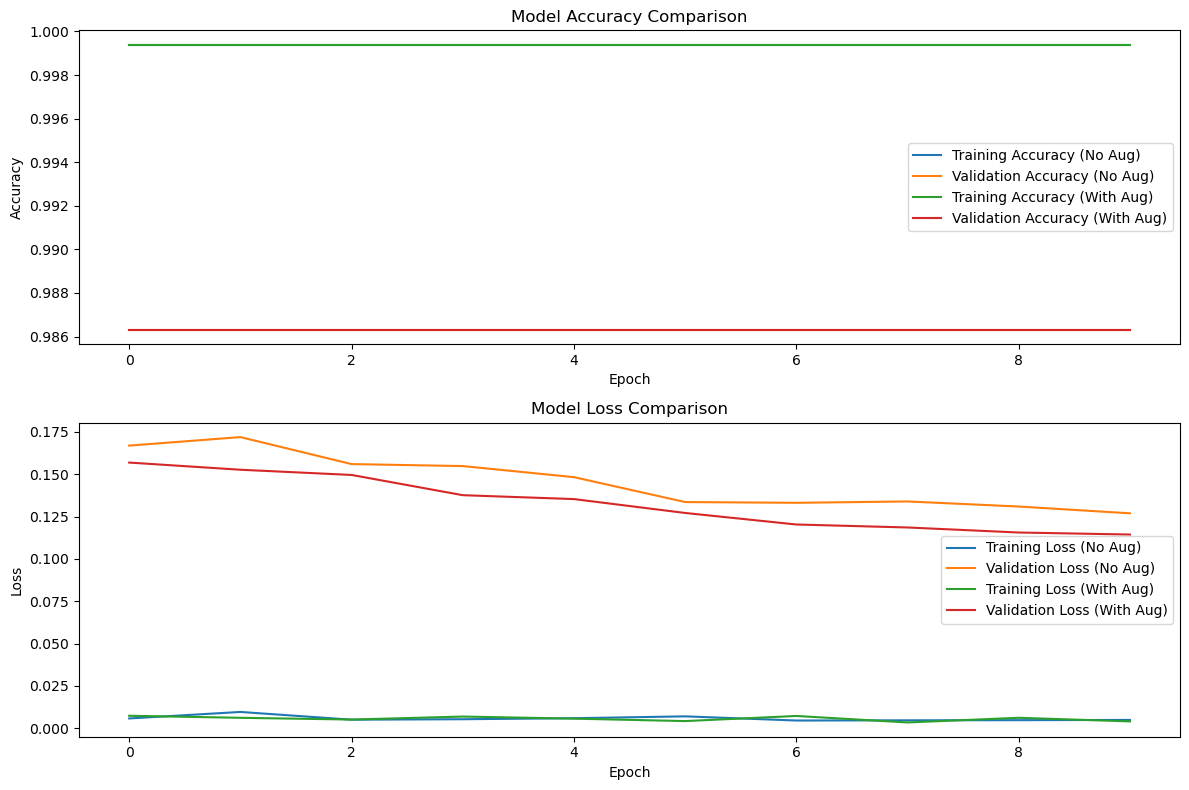

In [42]:
# Plot training & validation accuracy and loss for comparison
plt.figure(figsize=(12, 8))

# Plot accuracy comparison
plt.subplot(2, 1, 1)
plt.plot(history_without_aug.history['accuracy'], label='Training Accuracy (No Aug)')
plt.plot(history_without_aug.history['val_accuracy'], label='Validation Accuracy (No Aug)')
plt.plot(history_with_aug.history['accuracy'], label='Training Accuracy (With Aug)')
plt.plot(history_with_aug.history['val_accuracy'], label='Validation Accuracy (With Aug)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss comparison
plt.subplot(2, 1, 2)
plt.plot(history_without_aug.history['loss'], label='Training Loss (No Aug)')
plt.plot(history_without_aug.history['val_loss'], label='Validation Loss (No Aug)')
plt.plot(history_with_aug.history['loss'], label='Training Loss (With Aug)')
plt.plot(history_with_aug.history['val_loss'], label='Validation Loss (With Aug)')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Print comparison summary
print("\n--- Performance Comparison ---")
print(f"Without Augmentation - Test Accuracy: {accuracy_without_aug:.4f}, Test Loss: {loss_without_aug:.4f}")
print(f"With Augmentation - Test Accuracy: {accuracy_with_aug:.4f}, Test Loss: {loss_with_aug:.4f}")


--- Performance Comparison ---
Without Augmentation - Test Accuracy: 0.9863, Test Loss: 0.1167
With Augmentation - Test Accuracy: 0.9863, Test Loss: 0.1142


Conclusion: As the previous task, the results show a promising system to identify defective products, however, the lack of non-defective products reduces 
the model credibility since it cannot test this part of the model. With the Augmentation feature, which could reduce model's results due to its changes such as changes in lighting, orientation, or production conditions, the model results were still as good as before although it lacks non-defective products.